In [1]:
# Code to reload modules automatically
%load_ext autoreload
%autoreload 2

In [2]:
# General imports
import cv2
from skimage import io
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

# Crowd counting
This project presents an algorithm capable of counting and locating people on a beach. 

## Show labeled images


To begin, we load the information that we will use in the algorithm.

In [3]:
annotations = pd.read_csv('images/annotations.csv', header=None, names=['class', 'x', 'y', 'image', 'w', 'h'])
images_paths = list(Path('images').glob('*.jpg'))

width, height = annotations[['w', 'h']].mean().astype(int)

# Load images and annotations
images_info = [
    {
        "image": io.imread(path).astype(np.uint8),
        "annotation": annotations[annotations['image'] == path.name][['x', 'y']],
    } 
    for path in images_paths]

# Get the images of interest (Remove reference image)
images_info = images_info[1:]

Display the images with their respective labels.

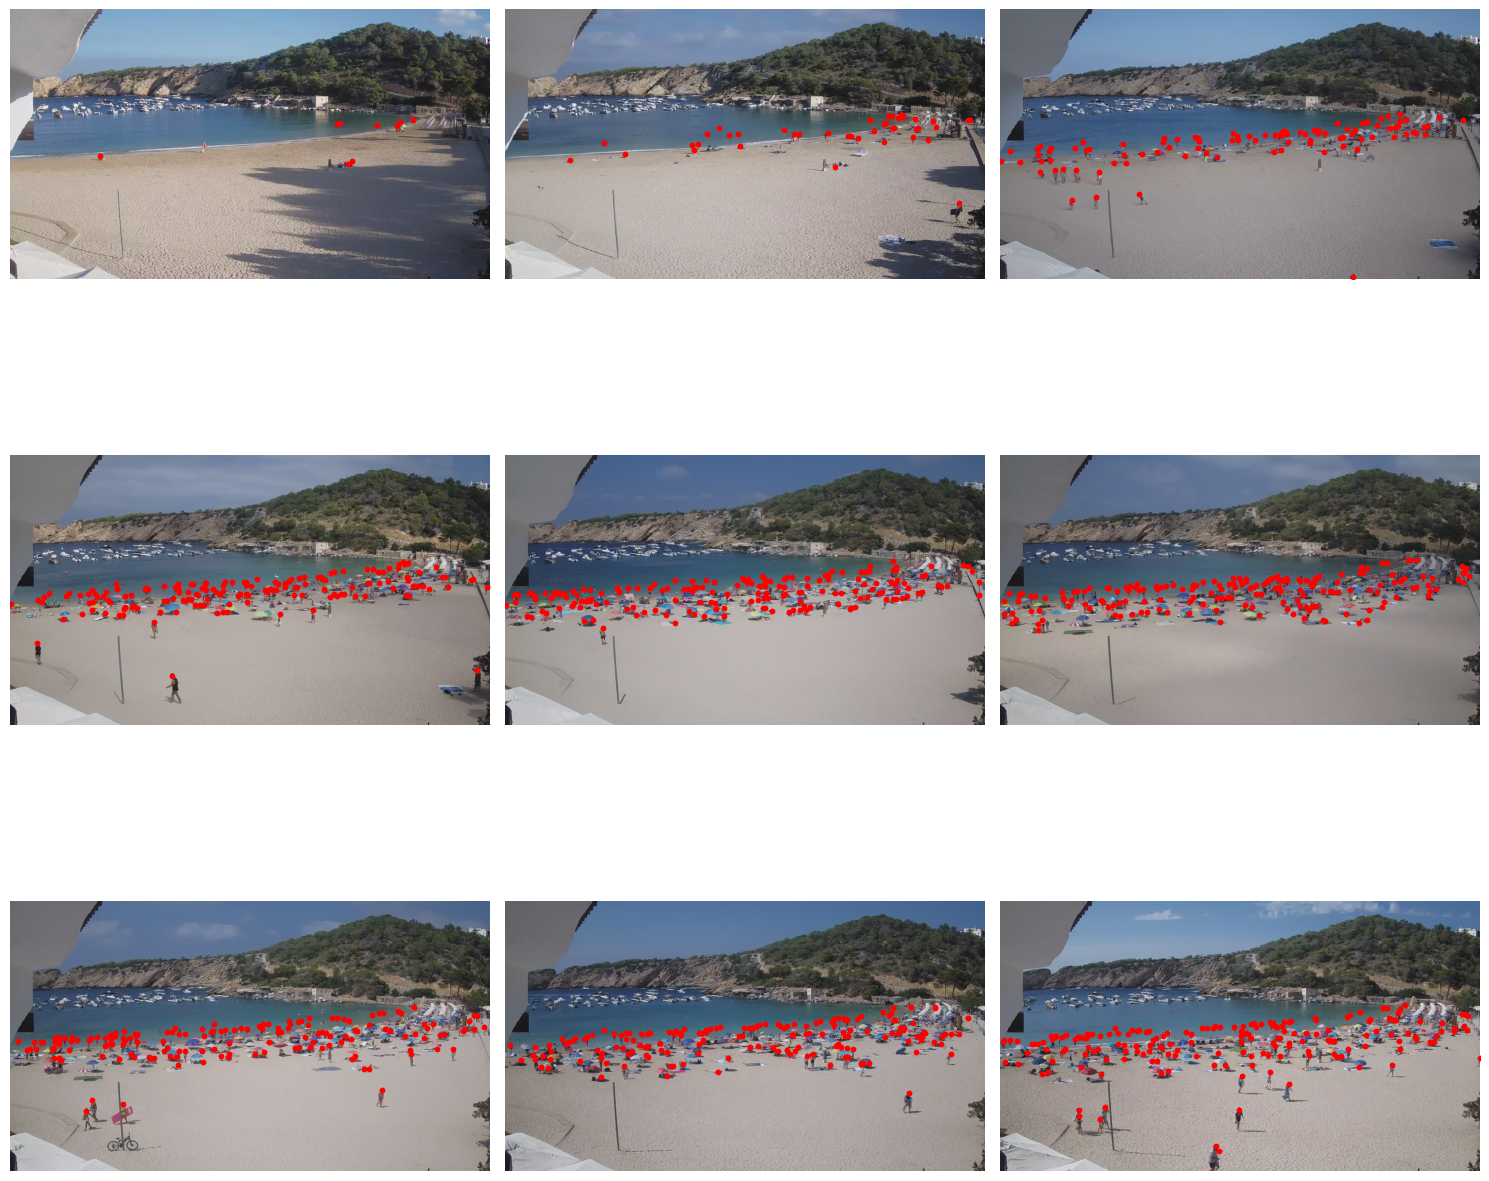

In [4]:
n_cols = 3
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

axes = axes.flatten()

for i, info in enumerate(images_info):
    image = info['image']
    annotation = info['annotation']
    axes[i].imshow(image, cmap='gray')
    axes[i].scatter(annotation['x'], annotation['y'], color='red', marker='o', s=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Algorithm execution
First we need take the images.

In [5]:
images = [info['image'] for info in images_info]

Now we run the person detection algorithm. For image 8 all intermediate results are shown to illustrate the algorithm. 

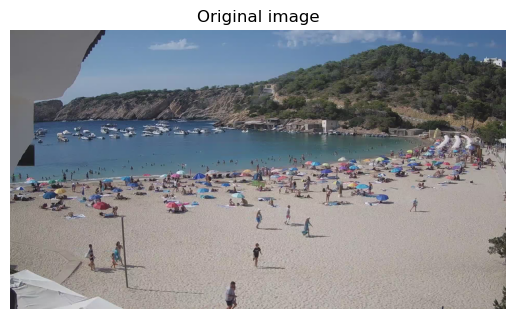

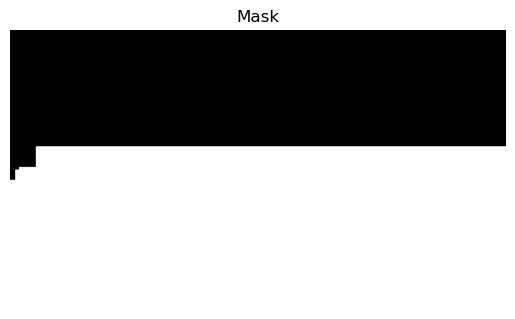

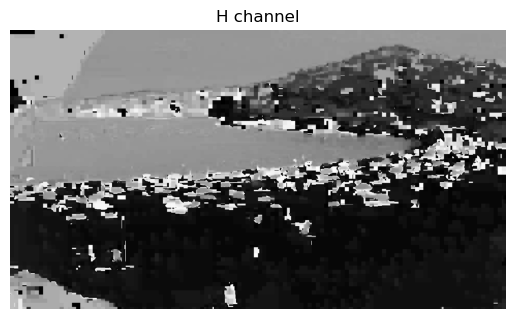

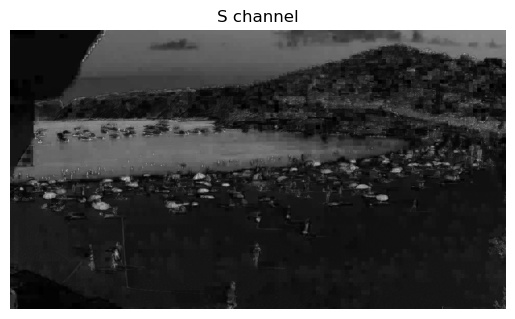

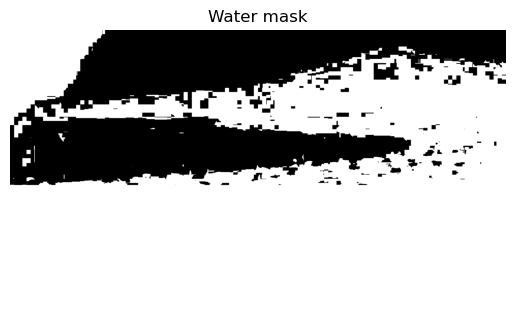

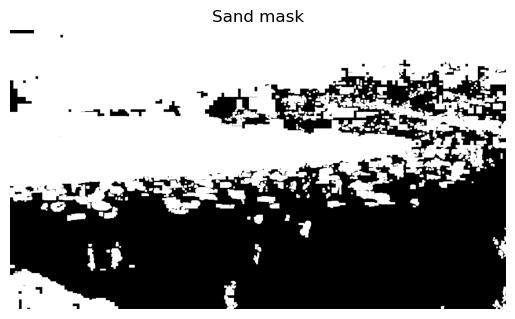

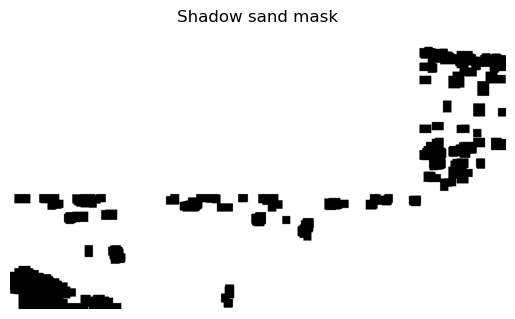

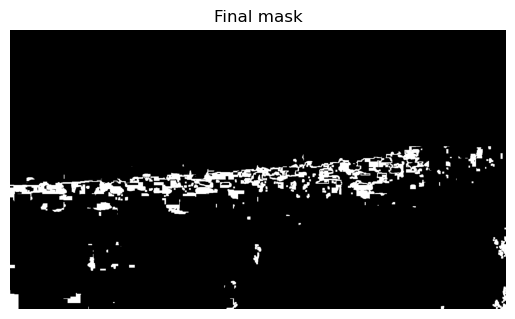

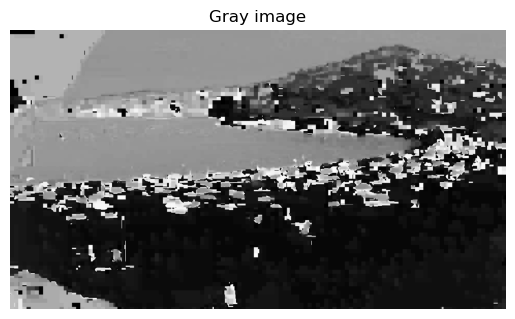

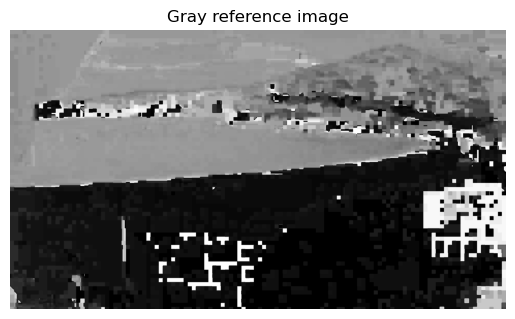

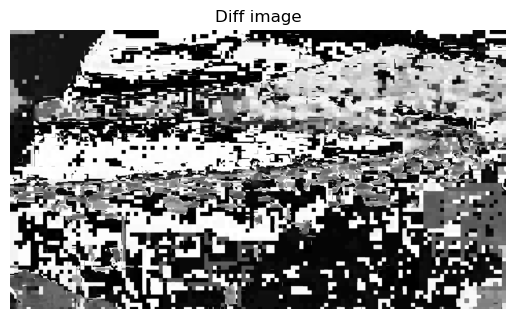

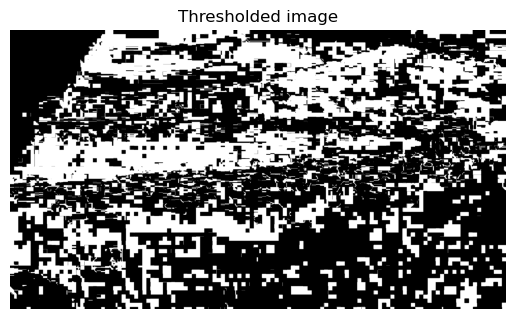

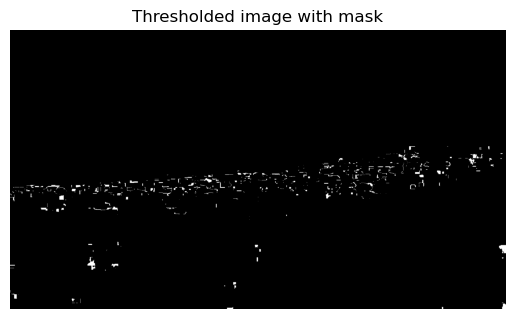

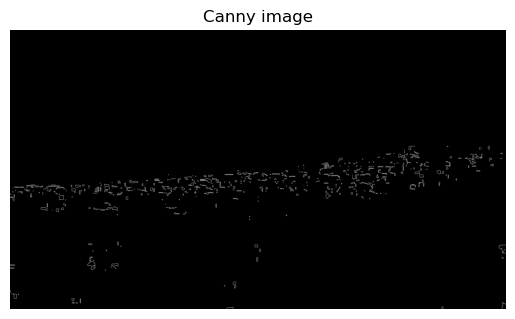

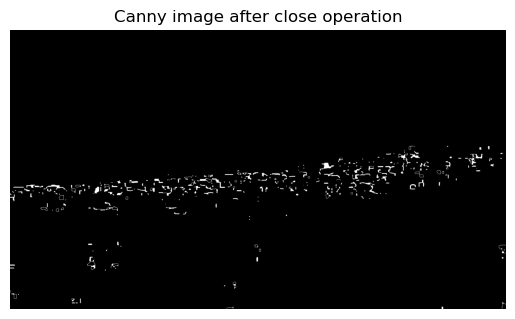

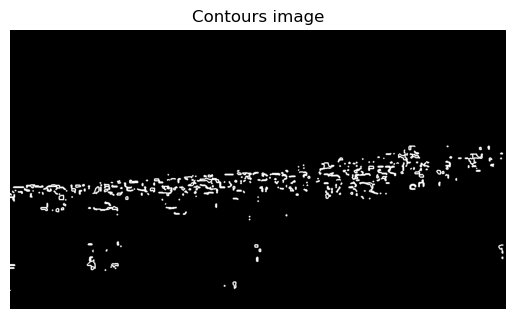

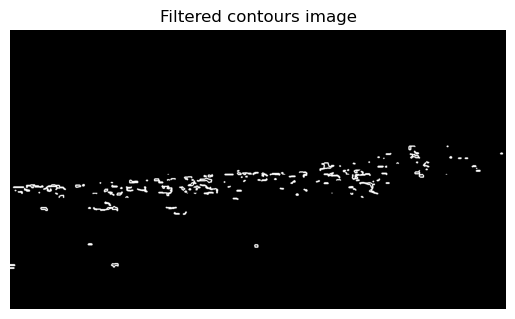

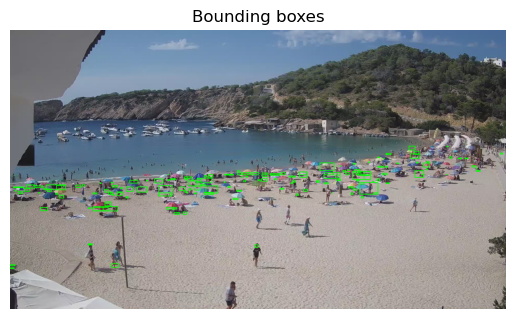

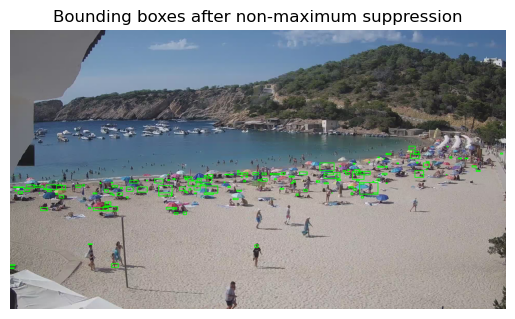

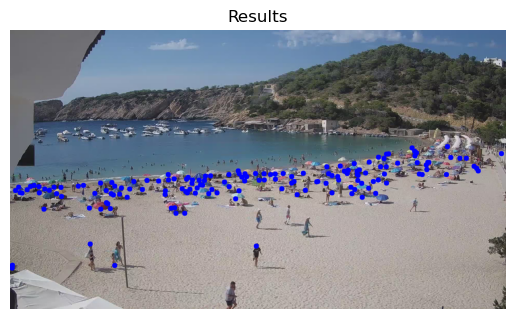

In [6]:
from lib.evaluate import evaluate_method
from methods.combined import locate_people

# Parameters of the algorithm
threshold = 200
stride=90
patch_size=(200, 200)
aspect_ratio_threshold=1.3

# Execute the algorithm
results = [locate_people(image, threshold, stride, patch_size, aspect_ratio_threshold, debug=idx==8) for idx, image in enumerate(images)]


## Evaluation
Next, we will evaluate the results obtained visually, and then we will review the concrete performance at the image and person level.

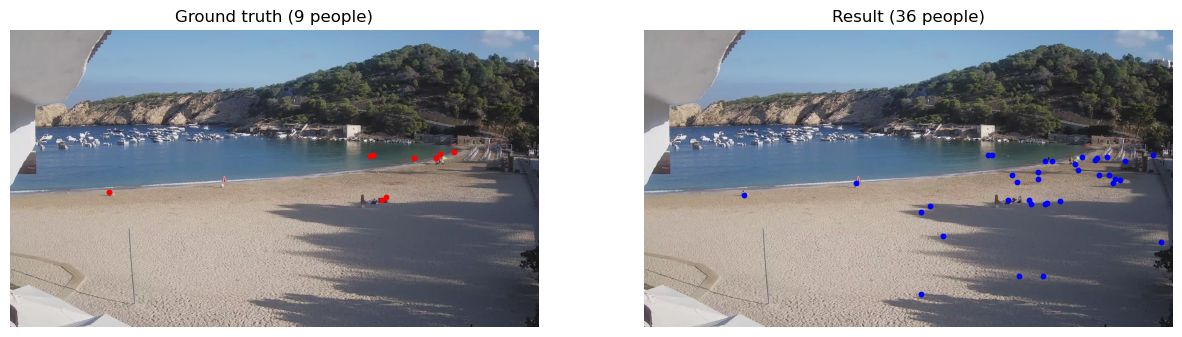

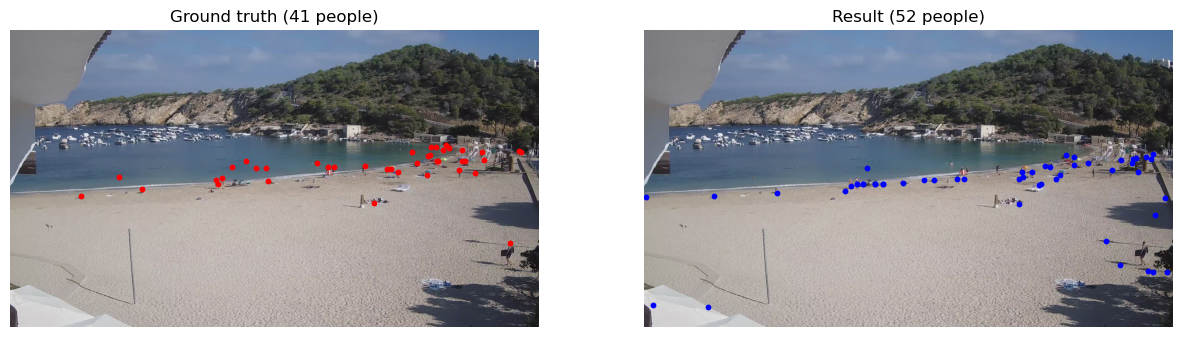

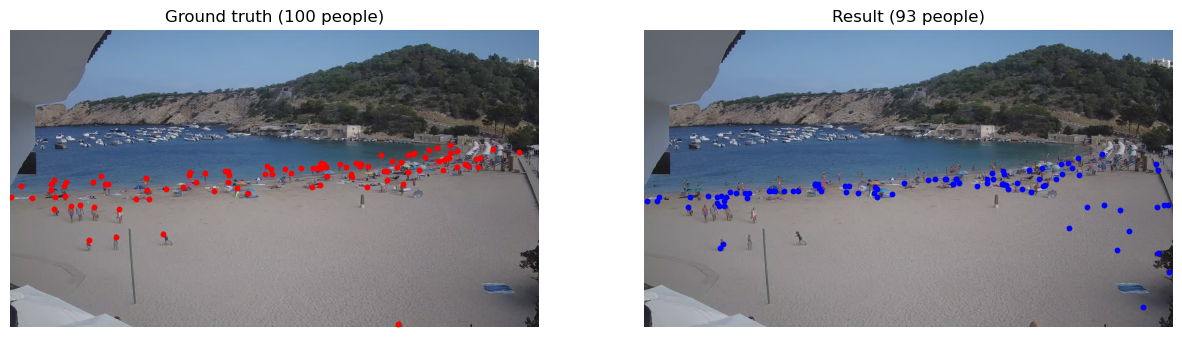

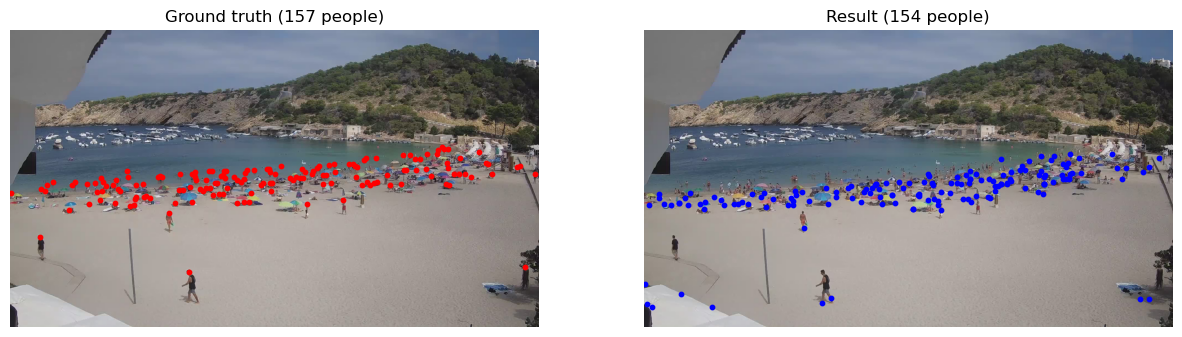

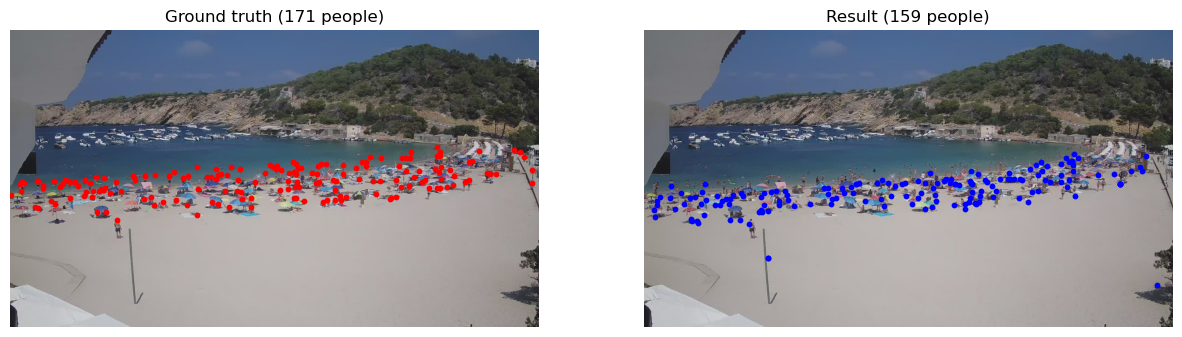

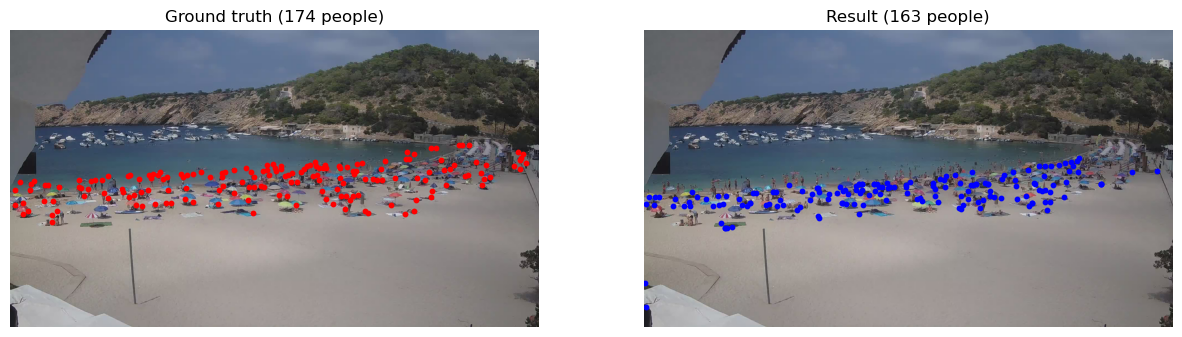

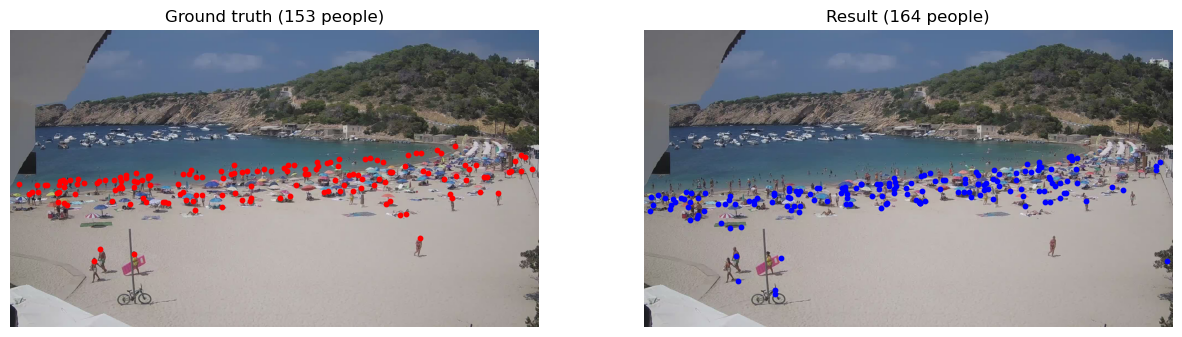

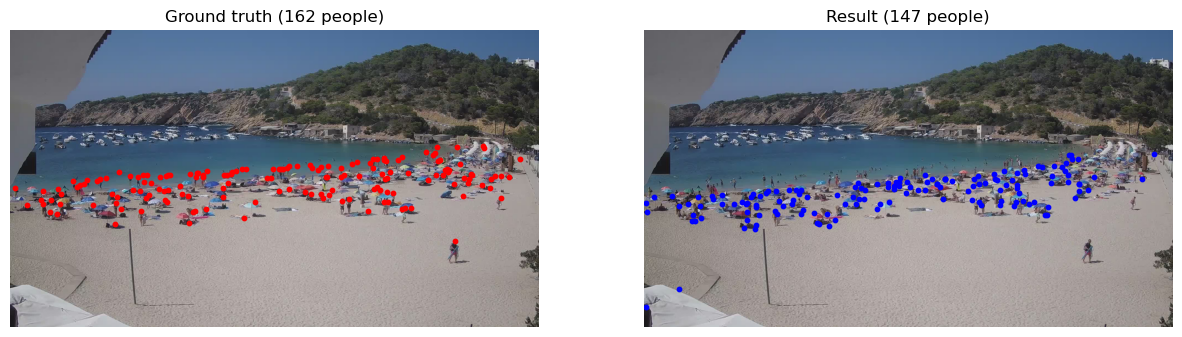

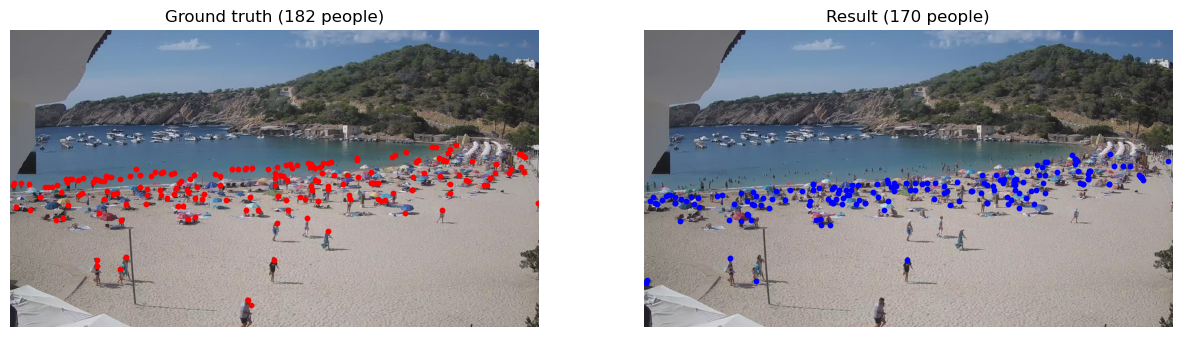

In [7]:
from lib.plot import plot_results_different_figures

labels = [info["annotation"].copy()  for info in images_info]
res = evaluate_method(all_results=results, all_labels=labels, width=width, height=height, max_distance=150)

plot_results_different_figures(images, results, labels, save_images=True)

It is observed that the results align correctly with the annotations in most cases, although there seem to be problems when there are few people in the image.

### Image level evaluation
In this section the algorithm is evaluated at the image level. The mean square error (MSE) between the number of detected persons and the number of real persons is calculated. The Pearson correlation coefficient (PCC) between the number of detected persons and the number of real persons is also evaluated.

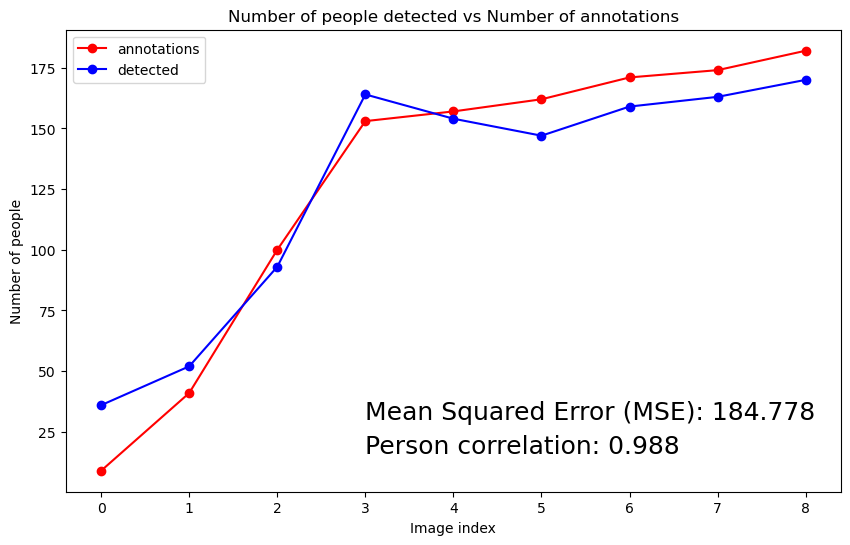

In [8]:
# Take the number of people detected and the number of annotations
n_detected = np.array([len(result) for result in results])
n_annotations = np.array([len(label_set) for label_set in labels])

# Take the indices that sort the number of annotations
sorted_indices = np.argsort(n_annotations)

# Sort the number of annotations and the number of detected people according to the indices
n_annotations = n_annotations[sorted_indices]
n_detected = n_detected[sorted_indices]

# Get the MSE and calculate the person correlation
mse_value = res['image_level']['value']
person_correlation = np.corrcoef(n_annotations, n_detected)[0, 1]


# Plot the number of annotations and the number of detected people to check if there is a correlation
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(n_annotations, 'ro-')
ax.plot(n_detected, 'bo-')
ax.legend(['annotations', 'detected'])
ax.set_xlabel('Image index')
ax.set_ylabel('Number of people')
ax.set_title('Number of people detected vs Number of annotations')
ax.text(3, 30, f'Mean Squared Error (MSE): {mse_value:.3f}', fontsize=18)
ax.text(3, 16, f'Person correlation: {person_correlation:.3f}', fontsize=18)
plt.show()

The error obtained is low, and the positive correlation between the detections and the actual number of people is high. This indicates that the model is able to correctly detect the number of people in the image.

### Person level evaluation
This section evaluates the algorithm at the individual level. Various metrics such as accuracy, recall and F1-score are calculated.

In [9]:
from IPython.display import display, HTML

# Take the metrics of the person level
person_level = res['person_level']['metrics']
keys = ['accuracy', 'precision', 'recall', 'f1']

# Extract the mean and std of each metric
mean_values = [person_level[key] for key in keys]
std_values = [person_level[f'{key}_std'] for key in keys]

# Create a dataframe with the mean and std of each metric
values_df = pd.DataFrame({'mean': mean_values, 'std': std_values}, index=keys)


display(HTML(values_df.to_html()))

We obtain a good average F1-Score (0.778).